In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [0]:
# read data from file
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [0]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

### Removing features

In [0]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [0]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [0]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


### Filling Missing values

In [0]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [0]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [0]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [0]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [0]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [0]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Resolution', 'SIM Slot(s)', 'RAM', 'Pixel Density',
       'Processor_frequency', 'os_name', 'Height',
       'Screen to Body Ratio (calculated)', 'SIM 2', 'Sim1', 'Screen Size',
       'Internal Memory', 'Num_cores', 'Capacity', 'Brand', 'Weight'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Resolution', 'RAM', 'Pixel Density', 'Processor_frequency',
       'Height', 'Screen to Body Ratio (calculated)', 'Screen Size',
       'Internal Memory', 'Capacity', 'Weight',
       'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'os_name_Android', 'os_name_Blackberry',
       'os_name_KAI', 'os_name_Nokia', 'os_name_Other', 'os_name_Tizen',
       'os_name_iOS', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other',
       'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'Num_cores_312', 'Num_cores_Deca',
       'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa', 'Num_c

In [0]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [0]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


#### Check the shape of the test and train data

In [0]:
#Check the shape of the training data and testing data
train_new.shape, test_new.shape

((341, 88), (119, 87))

#### Perform the head operation to get a feel for the test & train data and make basic observations

In [0]:
train_new.head()
# There is a PhoneID column which is an indicator column and does not play any role decision making.
# We see categorical variables coded as dummy variables which is an important observation and will be 
# used later on in the model

,PhoneId,Resolution,RAM,Pixel Density,Processor_frequency,Height,Screen to Body Ratio (calculated),Screen Size,Internal Memory,Capacity,Weight,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,...,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
0,0,20,4,403,1.8,157.9,80.68,6.26,64,4000,182,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5
1,1,8,3,271,1.8,156.2,80.85,6.20,32,4230,168,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.5
2,2,25,3,409,2.1,157.0,83.68,6.30,32,3500,168,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.4
3,4,24,4,411,2.2,159.8,74.78,6.00,64,3300,169,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.3
4,5,16,4,396,2.2,160.4,84.23,6.50,64,3750,175,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4


In [0]:
test_new.head()
# There is a PhoneID column which is an indicator column and does not play any role decision making
# There is no Rating column in test_new since this you will have to predict by building a working model
# on the train_data

,PhoneId,Resolution,RAM,Pixel Density,Processor_frequency,Height,Screen to Body Ratio (calculated),Screen Size,Internal Memory,Capacity,Weight,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,...,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,3,5,2,271,1.8,156.2,80.85,6.20,16,4230,168,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,11,12,4,402,1.8,156.0,81.60,6.20,64,5000,205,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13,25,6,409,2.0,156.7,83.84,6.30,64,3500,169,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,16,16,4,409,2.0,156.7,83.84,6.30,64,3500,169,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19,20,4,403,1.8,158.6,77.43,5.99,64,4000,181,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Create staging DataFrames

In [0]:
# Create X_train_new which will hold all columns except PhoneID and Rating using train_new
# Create Y_train_new which will only hold the Rating column present in train_new, note that the dataframe maintains integrity of the PhoneID 
# which is very essential

# Create X_test_new which will hold all columns except PhoneID
# There is no Y_test_new for obvious reasons as this is what you will be predicting 

X_train_new = train_new.drop(['PhoneId','Rating'],axis=1)
Y_train_new_rating_discrete = train_new['Rating'] 
Y_train_new_rating_binary   = train_new['Rating'].map(lambda x: 1 if x >= 4 else 0)

X_test_new = test_new.drop(['PhoneId'],axis=1)

#### Perform a decribe function on X_train_new and X_test_new to check std, mean and other parameters which will help you understand the data better in terms of dummy variables, null values, possible outliers etc.

In [0]:
X_train_new.describe()

,Resolution,RAM,Pixel Density,Processor_frequency,Height,Screen to Body Ratio (calculated),Screen Size,Internal Memory,Capacity,Weight,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,...,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,9.592375,11.120235,344.211144,1.792551,149.946394,72.353343,5.462317,46.369501,3191.307918,161.343109,0.002933,0.759531,0.152493,0.085044,0.906158,0.005865,0.005865,0.002933,0.020528,0.002933,0.055718,0.211144,0.020528,0.683284,0.085044,0.020528,0.020528,0.958944,0.002933,0.005865,0.029326,0.035191,0.580645,0.017595,0.325513,0.002933,0.005865,0.055718,0.023460,0.0,...,0.017595,0.049853,0.017595,0.008798,0.008798,0.011730,0.011730,0.002933,0.005865,0.026393,0.017595,0.002933,0.043988,0.002933,0.002933,0.005865,0.043988,0.011730,0.043988,0.005865,0.061584,0.002933,0.041056,0.008798,0.017595,0.011730,0.002933,0.011730,0.002933,0.129032,0.026393,0.0,0.023460,0.002933,0.002933,0.076246,0.061584,0.008798,0.011730,0.002933
std,5.953827,61.320855,88.161129,0.451598,9.192305,9.357839,0.742529,46.435453,932.533527,22.305556,0.054153,0.427996,0.360026,0.279357,0.292037,0.076471,0.076471,0.054153,0.142006,0.054153,0.229714,0.408720,0.142006,0.465879,0.279357,0.142006,0.142006,0.198711,0.054153,0.076471,0.168965,0.184532,0.494179,0.131668,0.469255,0.054153,0.076471,0.229714,0.151583,0.0,...,0.131668,0.217962,0.131668,0.093520,0.093520,0.107827,0.107827,0.054153,0.076471,0.160536,0.131668,0.054153,0.205370,0.054153,0.054153,0.076471,0.205370,0.107827,0.205370,0.076471,0.240751,0.054153,0.198711,0.093520,0.131668,0.107827,0.054153,0.107827,0.054153,0.335728,0.160536,0.0,0.151583,0.054153,0.054153,0.265782,0.240751,0.093520,0.107827,0.054153
min,2.000000,1.000000,143.000000,1.000000,115.600000,23.600000,2.400000,0.000000,1020.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [0]:
X_test_new.describe()

,Resolution,RAM,Pixel Density,Processor_frequency,Height,Screen to Body Ratio (calculated),Screen Size,Internal Memory,Capacity,Weight,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,...,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.0,119.0,119.0,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.0,119.0,119.000000,119.000000,119.000000,119.000000,119.000000,119.0,119.0,119.000000,119.000000,119.000000,...,119.000000,119.000000,119.0,119.000000,119.000000,119.0,119.0,119.000000,119.000000,119.000000,119.000000,119.0,119.000000,119.0,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.0,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.0,119.0
mean,9.294118,11.983193,334.731092,1.768403,150.277679,71.955630,5.463445,48.336134,3233.764706,164.000000,0.0,0.789916,0.184874,0.025210,0.957983,0.0,0.0,0.0,0.033613,0.0,0.008403,0.235294,0.025210,0.714286,0.025210,0.025210,0.042017,0.932773,0.0,0.0,0.016807,0.008403,0.630252,0.025210,0.319328,0.0,0.0,0.008403,0.050420,0.008403,...,0.016807,0.050420,0.0,0.016807,0.016807,0.0,0.0,0.008403,0.008403,0.025210,0.033613,0.0,0.025210,0.0,0.008403,0.0,0.042017,0.016807,0.042017,0.008403,0.033613,0.0,0.050420,0.016807,0.025210,0.033613,0.0,0.008403,0.0,0.184874,0.008403,0.008403,0.016807,0.0,0.008403,0.067227,0.058824,0.008403,0.0,0.0
std,5.618301,65.670335,102.821278,0.471133,8.516004,10.349265,0.759304,49.842001,772.097887,16.698726,0.0,0.409091,0.389837,0.157426,0.201476,0.0,0.0,0.0,0.180994,0.0,0.091670,0.425976,0.157426,0.453664,0.157426,0.157426,0.201476,0.251473,0.0,0.0,0.129090,0.091670,0.484778,0.157426,0.468188,0.0,0.0,0.091670,0.219736,0.091670,...,0.129090,0.219736,0.0,0.129090,0.129090,0.0,0.0,0.091670,0.091670,0.157426,0.180994,0.0,0.157426,0.0,0.091670,0.0,0.201476,0.129090,0.201476,0.091670,0.180994,0.0,0.219736,0.129090,0.157426,0.180994,0.0,0.091670,0.0,0.389837,0.091670,0.091670,0.129090,0.0,0.091670,0.251473,0.236289,0.091670,0.0,0.0
min,2.000000,1.000000,114.000000,1.100000,111.500000,18.890000,1.800000,0.000000,1020.000000,105.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,5.000000,2.000000,269.500000,1.400000,146.550000,68.835000,5.100000,16.000000,3000.000000,154.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,

### Understanding Correlation 

In [0]:
# Checking for correlation only for the first 10 discrete variables
X_train_corr = X_train_new.iloc[:,[0,1,2,3,4,5,6,7,8,9]]
X_train_corr.head()

,Resolution,RAM,Pixel Density,Processor_frequency,Height,Screen to Body Ratio (calculated),Screen Size,Internal Memory,Capacity,Weight
0,20,4,403,1.8,157.9,80.68,6.26,64,4000,182
1,8,3,271,1.8,156.2,80.85,6.20,32,4230,168
2,25,3,409,2.1,157.0,83.68,6.30,32,3500,168
3,24,4,411,2.2,159.8,74.78,6.00,64,3300,169
4,16,4,396,2.2,160.4,84.23,6.50,64,3750,175


In [0]:
correlations = X_train_corr.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

correlations.tail(10)

# The tail of the dataframe has the information about highest correlation between features,
# where as the head has details about features that have least correlation

# Observe that Screen Size and Screen to Body Ratio are highly correlated, We don't know if they are
# positively or negatively correlated yet. We will find that out visually
# Similarly Height and Screen Size are correlated.

# Intution tells me that they will be positvely correlated, meaning any increase in Height of the 
# phone will result in an increase of the Screen Size and vice versa. 

#A bigger phone screen (Screen Size) means the phone is lenghtier (Height). 

,level_0,level_1,0
80,Height,Weight,0.642595
81,Weight,Height,0.642595
82,Weight,Capacity,0.687891
83,Capacity,Weight,0.687891
84,Screen to Body Ratio (calculated),Height,0.744119
85,Height,Screen to Body Ratio (calculated),0.744119
86,Screen Size,Height,0.861143
87,Height,Screen Size,0.861143
88,Screen to Body Ratio (calculated),Screen Size,0.930492
89,Screen Size,Screen to Body Ratio (calculated),0.930492


#### Visual Interpretation of correlation  

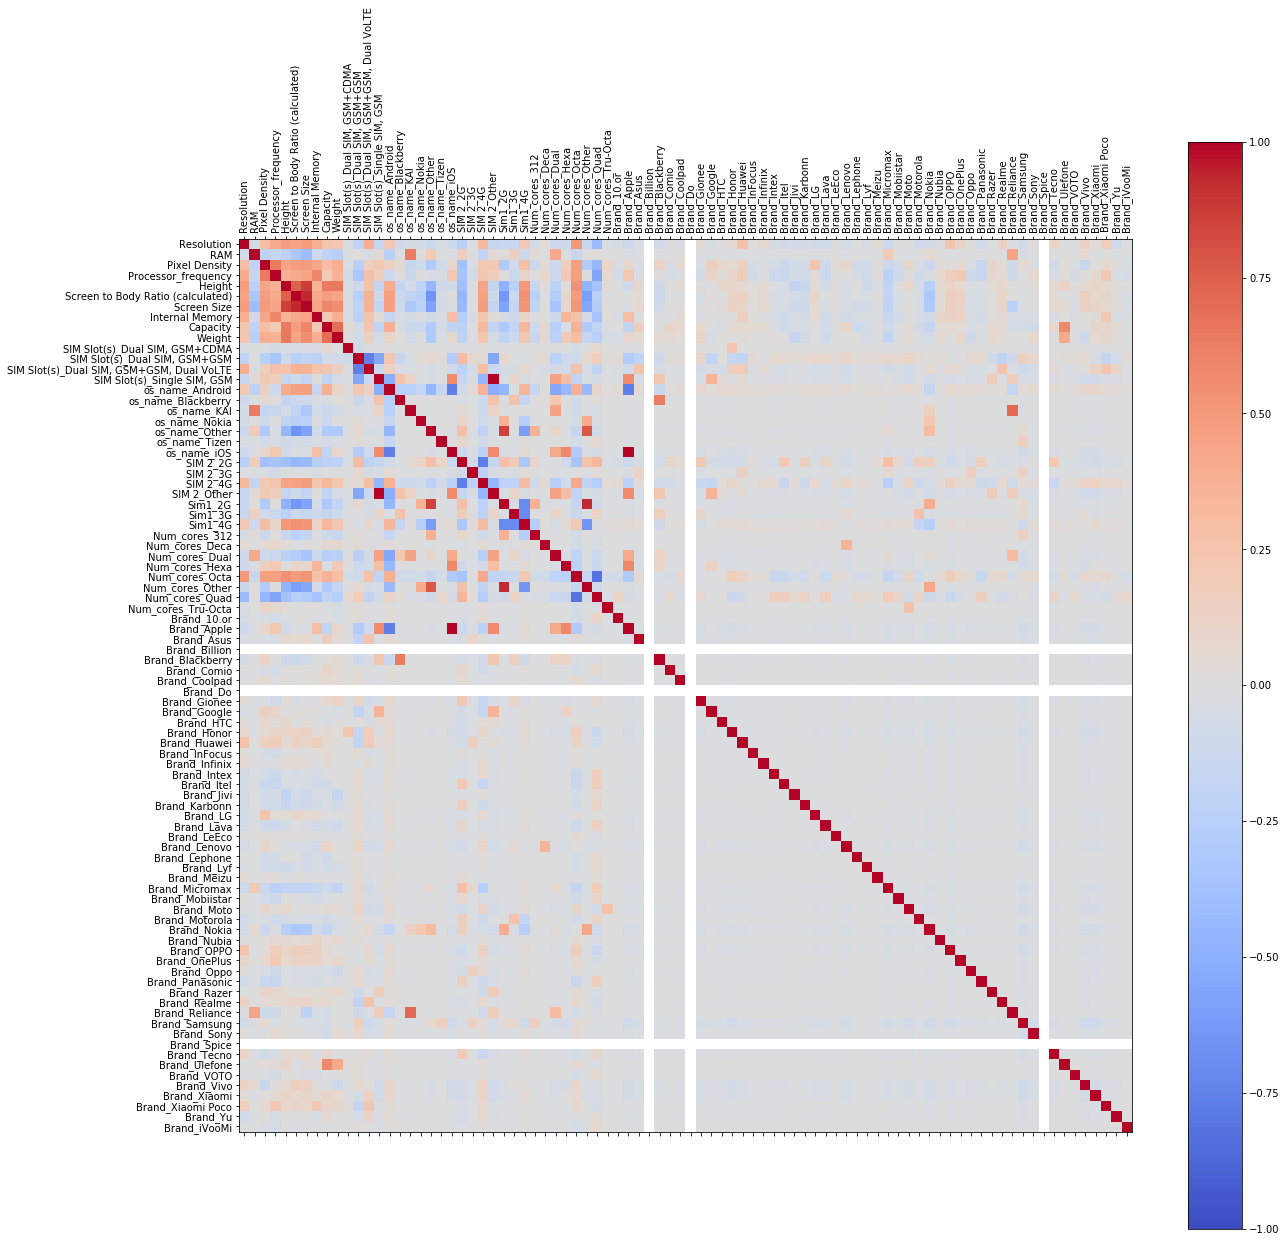

In [0]:
corr = X_train_new.corr()
fig = plt.figure()
fig.set_size_inches(20,20)
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train_new.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X_train_new.columns)
ax.set_yticklabels(X_train_new.columns)
plt.show()

# We can clearly see that Screen Size is positively correlated with Height and Screen to body Ratio
# There are other positively correlated variables too. Another good easy to understand example is 
# Brand_Apple and os_name_iOS.

# Look against the line of 'Brand_Apple' and compare it with all the top columns 
# It's obvious isn't it that an Apple iPhone / product user will have an iOS operating 
# system on his/her device. He/she cannot have an Android on his Apple iPhone. 
# This now introduces to you negative correlation. Notice how Brand_Apple and os_name_Andriod are
# negatively correlated (dark blue), which means Apple folks cannot have Android OS

### Let's plot some interesting graphs

In [0]:
#Assigning a dataframe to capture visuals on the discrete data, note that how we have two dataframes where the Y_train_new has been desgined to 
#hold discrete value as well as binary value for the ease of interpretation
X_train_visual_rating_binary = pd.concat([X_train_new,Y_train_new_rating_binary],axis=1)
X_train_visual_rating_discrete = pd.concat([X_train_new,Y_train_new_rating_discrete],axis=1)

#### RAM vs Capacity - Box Plot
##### The plot is indicating me that phones with high RAM have larger Capacity values ( for the first few bars atleast ) or vice versa,  may be the phones > 16GB have good design where capacity is optimized to a lower value but the trend remains the same. But did the users like the phone ?? Note that there is no correlation between RAM and Capacity so they are good variables/features to decide on if the user would have liked the phone or not.

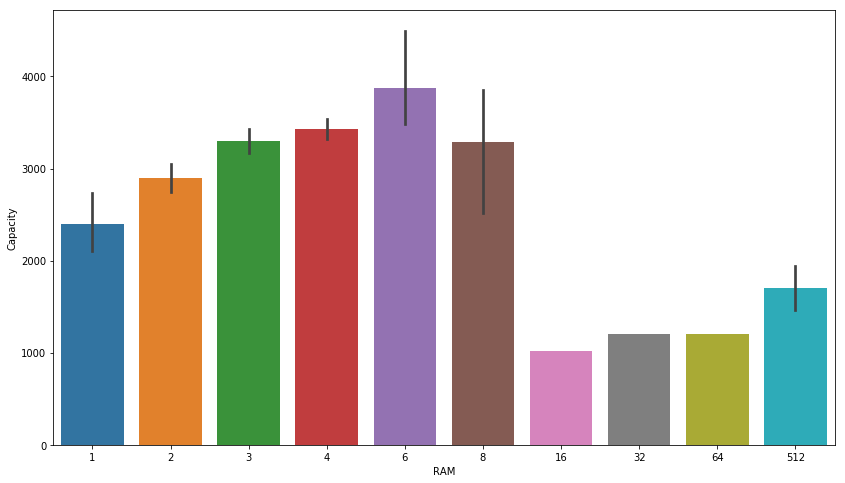

In [0]:
plt.figure(figsize=(14,8))
sns.barplot(x='RAM',y='Capacity',data=X_train_visual_rating_binary)

#### RAM vs Capacity - Scatter Plot
##### I was not able to derive any inference from this plot for the RAM values of 2 GB to 64 GB as data is too much stacked. But it is very evident that folks with 512 units of RAM have disliked the phone, so that is intellgent data and I cannot treat those users / phones as outliers. It has to be 512 MB of RAM and not GB that's why they have disliked it. We don't have a phone with 512 GB of RAM yet or do we ? Samsung and 1+ , Are you guys listening ?

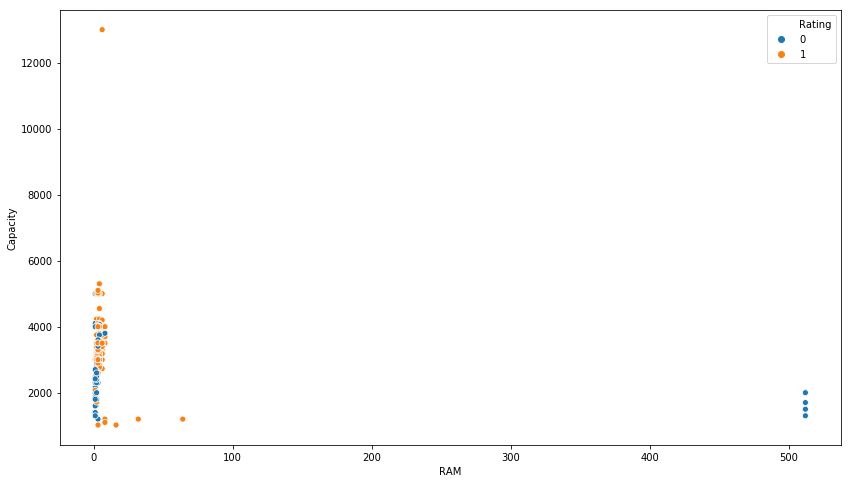

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='RAM',y='Capacity',hue='Rating',data=X_train_visual_rating_binary)

#### Screen Size vs Pixel Density - Box Plot
##### The plot is indicating me that if Screen Size increases then Pixel Density also seems to be increasing ( atleast for majority of the cases ), but its very hard to draw a trend here. In reality we would not like the phone which has large screen size and low pixel density. So what about those phones with Screen Size of 5.34, 6.22 and 5.84 ? Did the users like them ? The correlation heatmap of these two columns is at 0.5 ( balanced )

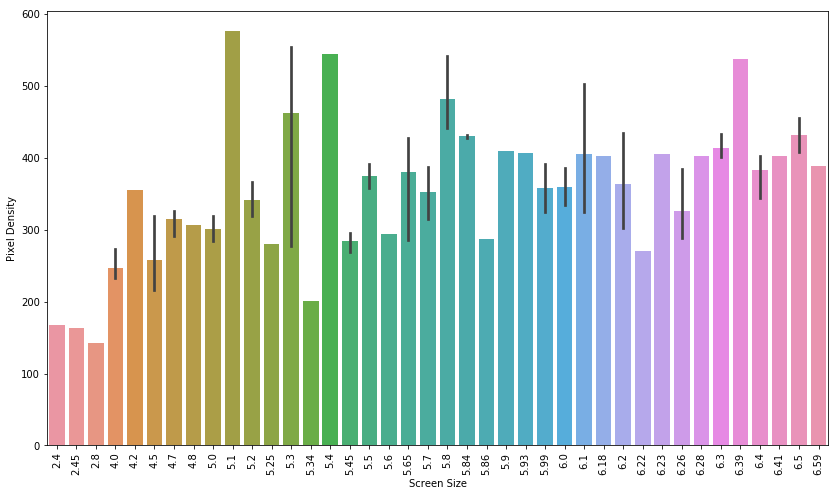

In [0]:
plt.figure(figsize=(14,8))
plt.xticks(rotation='vertical')
sns.barplot(x='Screen Size',y='Pixel Density',data=X_train_visual_rating_binary)

#### Screen Size vs Pixel Density - Scatter Plot
##### Most of the folks seem to like phones with Screen Size greater than 5 and Pixel Density greater than 300 the bottom left quadrant of points. That quadrant has fewer phones. If you look at the box plot above most of the phones have Screen Size greater than 5

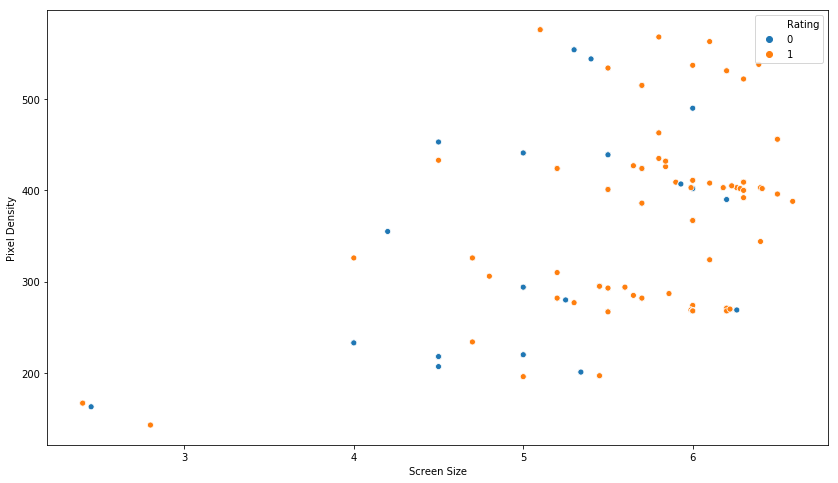

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Screen Size',y='Pixel Density',hue='Rating',data=X_train_visual_rating_binary)

#### Resolution vs Pixel Density - Box Plot
##### In reality high resoultion needs more pixles per square block. But it seems like Resolution 7, 13, 25 have similar Pixel Density. There is no linear trend observed. Correlation seems to be < 0.5

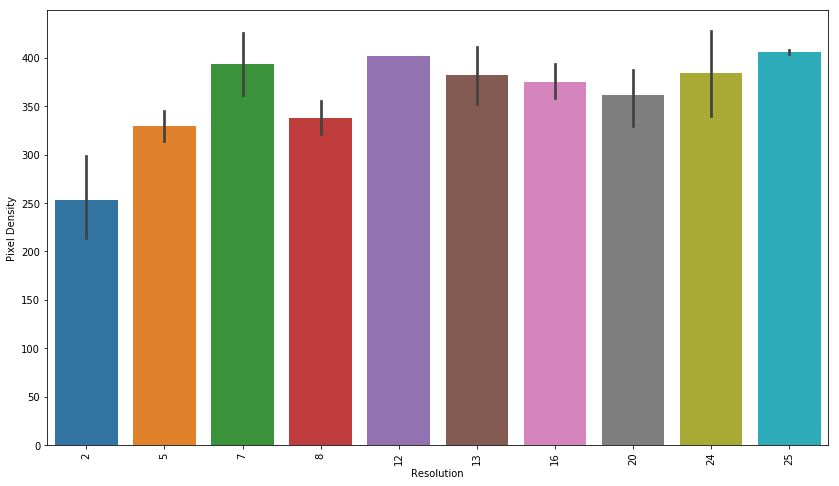

In [0]:
plt.figure(figsize=(14,8))
plt.xticks(rotation='vertical')
sns.barplot(x='Resolution',y='Pixel Density',data=X_train_visual_rating_binary)

#### Resolution vs Pixel Density - Scatter Plot
##### This is a hard scatter plot to interpret, Resolution < 15 and Pixel Density < 325 - take a look at the quadrant. It may have a pattern of dislikes. But again, this is very hard to judge.

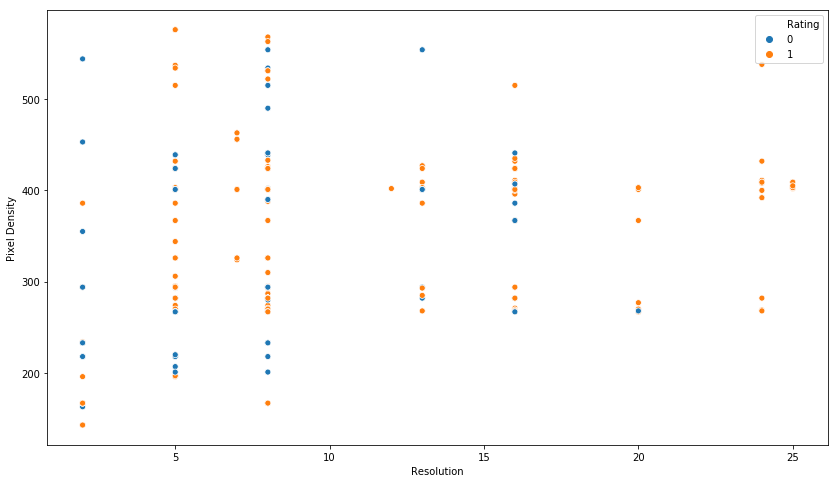

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Resolution',y='Pixel Density',hue='Rating',data=X_train_visual_rating_binary)

#### Internal Memory vs Weight - Box Plot
##### Is the phone with higher Internal Memory heavier ? I may have more apps if my phone has 512 GB of disk space so I may need a battery capacity of higher number to manage power. Let's plot that in the next graph. The columns have a correlation factor of 0.5. It also looks to me that folks with 4GB Internal Memory are more compared to 8,16,32. How did I make that obeservation ? 

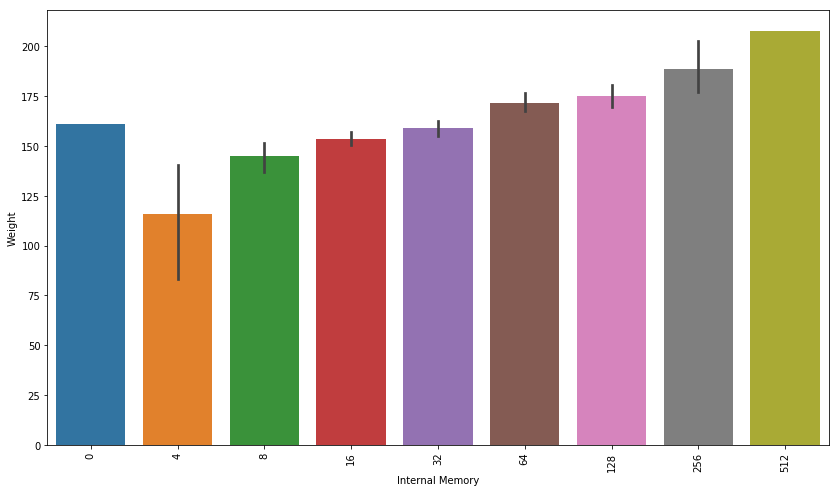

In [0]:
plt.figure(figsize=(14,8))
plt.xticks(rotation='vertical')
sns.barplot(x='Internal Memory',y='Weight',data=X_train_visual_rating_binary)

#### Internal Memory vs Weight - Scatter Plot
##### This is a hard scatter plot to interpret, because the value of Internal Memory is in multiples of 2 we don't really have a good plot. I feel < 32 GB of space and weight range of < 150 have not liked the phone. It actually makes literal sense in todays world. But we cannot go by intituions in real life data driven problems. 

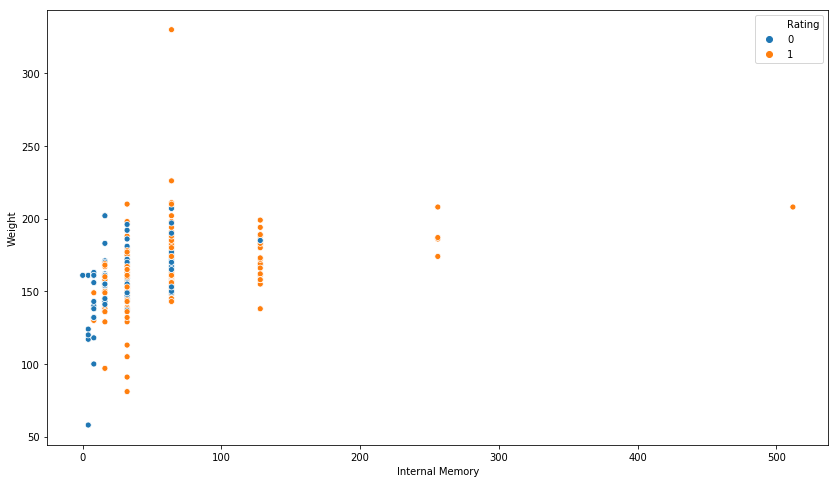

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Internal Memory',y='Weight',hue='Rating',data=X_train_visual_rating_binary)

#### Capacity vs Weight - Bar Plot
##### A bigger battery Capacity leads to inrease in its weight, its obvious in the real world and evident in the trend. There are phones with low Capacity numbers and higher weights - Will the users like it ? Let's look at it in our next plot 

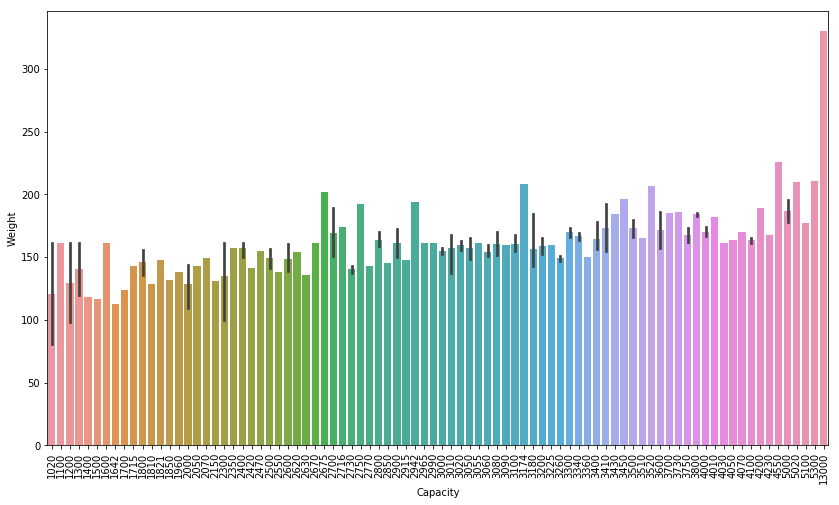

In [0]:
plt.figure(figsize=(14,8))
plt.xticks(rotation='vertical')
sns.barplot(x='Capacity',y='Weight',data=X_train_visual_rating_binary)

#### Capacity vs Weight - Scatter Plot
##### Our cut off rating is 4.0 , Though it is hard to visually interpret, it looks like most of the folks owning a phone within Capacity range of < 2500 and weight range of  < 160 appear to not like their phone.

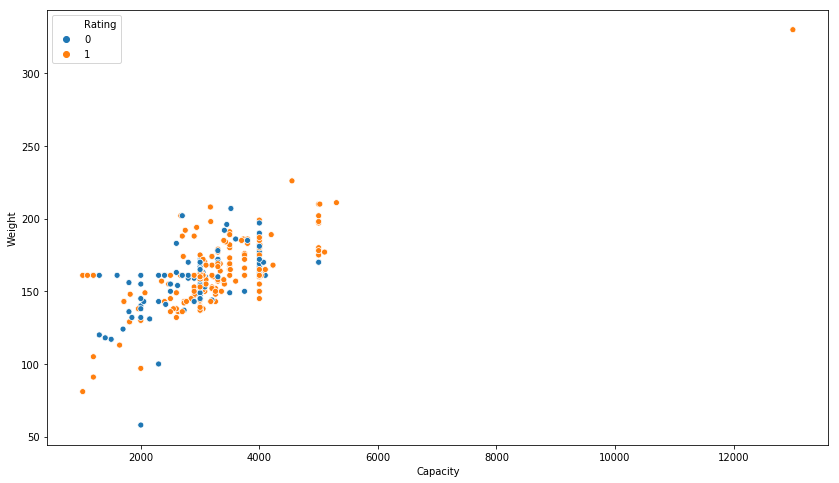

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Capacity',y='Weight',hue='Rating',data=X_train_visual_rating_binary)

##### I have done several more, but will limit it to the above so that everyone understands the plots. You can try plotting more graphs and see if you can get some more inference, I would love t#o hear more about your findings

### The MP Neuron Model

#### Some Key Points which we need to understand with respect to building a model

##### 1. The idea is to get the Train accuracy close to Test accuracy so that the model follows a generalized behaviour and I can use it on any type of data that comes in, if at all I happen to deploy it.
##### 2. The model is very primitive, it only takes binary as inputs and outputs a binary value. We will have to convert the discrete variables to binary to begin with.
##### 3. There are several ways to do it, after multiple iterations using mean(), median() functions over the features, I decided to go full visual using the help of above scatter plots wherever possible and kept the values to what I feel makes best sense and gives me better accuracy. 

### Key Factors & Observation for High Accuracy Score

#### 1. Dealing with correlation - 
##### I removed one of the columns in the group of columns which were correlated. You can see that I removed Weight, Height, Screen to Body Ratio & Resolution. Removing these columns helped me in increasing the accuracy to a greater extent, having them in my model would have resulted in bias situation where I would have predicted more 1's or more 0's ! I have run the code multiple times in combination logic to see which column arrangement & its values among discrete variables gives me best accuracy. It's time consuming, well so is the model ( primitive )

#### 2. Accounting for the direction using Scatter plot - 
##### If you see Brand_Apple and os_name_iOS though they are correlated I felt I should not remove one of the columns as the intellegence is lost about the column. In the model where intellegence is the key, I should keep as many columns as I can and this logic worked for me. I would need some experts to vouch as this is still under my scanner if this is the right way. There are discussion in MP Neuron if correlation really matters or not with respect to binary variables.  

#### 3. Binary Columns -
##### If I were to remove binary columns which are correlated ( Apple_Brand & os_name_iOS ) I obeserved a dip in accuracy.


### Evaluate direction of the column using Scatter plot

#### I will give two examples and the rest you can figure it out by yourself as to what is happening and how the lambda function is used

#### Example 1 - Brand_Apple vs Rating , Hue = Rating
##### Notice how all the Apple users have liked the phone. Now since they are Apple users they have the column Brand_Apple as '1' , That column is now intellegent enough as other rows in that column are '0' - I call this as positve direction which helps in the final score when the 1s across the rows are summed to check against the 'b' / threshold value parameter.

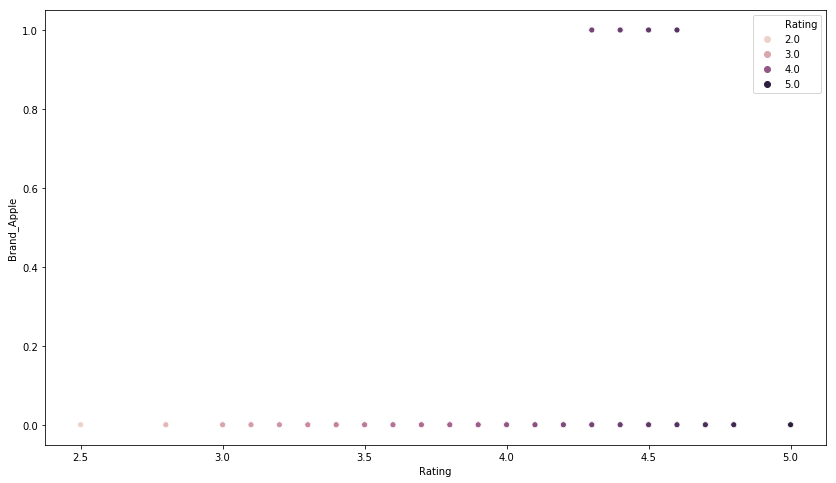

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Rating',y='Brand_Apple',hue='Rating',data=X_train_visual_rating_discrete)

#### Example 2 - Brand_Blackberry vs Rating , Hue = Rating
##### Notice how most of the Blackberry users have disliked the phone. Now since they are Blackberry users they have the column Brand_Blackberry as '1' , That column is now intellegent enough as other rows in that column are '0', but the rows which are '1' in the Brand_Blackberry column are going in the negative direction, it is brining down the rating value. We can also say that for rows which contain '0' we are certain that the user corresponding to that row would have liked some other phone. 

##### Hence I am converting the '0's in Brand_blackberry column to '1' and making the '1s' as '0', this would eventually imply that " Most Blackberry users who had the phone disliked it " 

##### Did you see what I did there ? I simply swapped the binaries so that now it makes more sense or in other words I am brininging in more intellegence for that column so that my predictions are accurate

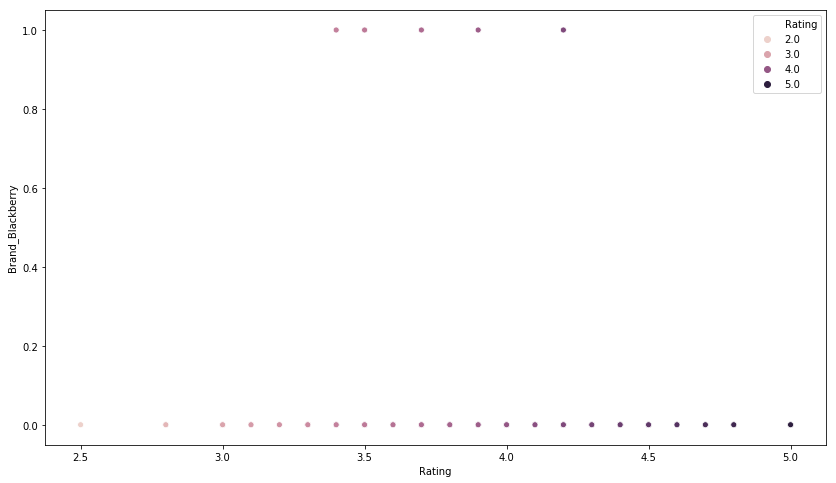

In [0]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Rating',y='Brand_Blackberry',hue='Rating',data=X_train_visual_rating_discrete)

#### I have plotted scatter plots for each and every categorical column there is in the above fashion, made inferences and coded the lambda function against the feature as seen below, the snippet becomes too long if I post all the details here. You can give it a try to interpret the results. 

##### 1. If the scatter is even then I have not changed anything and simply passed the feature to the model
##### 2. If the scatter is already driving towards positve direction, again no changes to the feature values
##### 3. If the scatter is already driving towards negative direction, lambda function is applied to reverse the direction to get better accuracy

### X_train_binarised & X_test_binarised 

In [0]:
# Please go through the comments against the feature, they are based out of the above 3 points on how I arrived at the conclusing of 
# swapping, retaining or completly ignoring

X_train_binarised = np.array([
#X_train_new['Weight'].map(lambda x: 1 if x > 153 else 0), # Removed due to correlation and accuracy increased
#X_train_new['Height'].map(lambda x: 1 if x > 151 else 0), # Removed due to correlation and accuracy increased
#X_train_new['Screen to Body Ratio (calculated)'].map(lambda x: 1 if x >= 55  else 0), # Removed due to correlation and accuracy increased
X_train_new['Pixel Density'].map(lambda x: 1 if x > 270 else 0),
X_train_new['Processor_frequency'].map(lambda x: 1 if x > 2.1 else 0),
X_train_new['Screen Size'].map(lambda x: 1 if x > 4.8 else 0),
X_train_new['RAM'].map(lambda x: 1 if x > 4 else 0),
#X_train_new['Resolution'].map(lambda x: 1 if x > 20 else 0), # Removed due to correlation and accuracy increased
X_train_new['Internal Memory'].map(lambda x: 1 if x > 64 else 0),
X_train_new['Capacity'].map(lambda x: 1 if x > 2100 else 0),
X_train_new['Brand_10.or'].map(lambda x: 0 if x >= 1 else 1), # 1 user has this phone and has not liked it. so its flipped
X_train_new['Brand_Apple'],#.map(lambda x: 0 if x=1), # 4 users have this phone and have liked it, hence no changes
X_train_new['Brand_Asus'],#.map(lambda x: 0 if x=1), # 4 users like this phone and 1 dislike, keep the field 
#X_train_new['Brand_Billion'].map(lambda x: 0 if x=1), # No Rows found, Removed to increase train accuracy due to scope of assignment
X_train_new['Brand_Blackberry'].map(lambda x: 0 if x>=1 else 1), # 3 Userd have disliked the phone hence its flipped
X_train_new['Brand_Comio'],#.map(lambda x: 0 if x=1), No changes 1 has liked it keep it
X_train_new['Brand_Coolpad'].map(lambda x: 0 if x >= 1 else 1), #flipped as 2 of them have disliked
#X_train_new['Brand_Do'].map(lambda x: 0 if x=1), # No Rows found, Removed to increase train accuracy due to scope of assignment
X_train_new['Brand_Gionee'],#.map(lambda x: 0 if x=1), # 50-50 column, as of now removed as there is no intellegence 
X_train_new['Brand_Google'],#.map(lambda x: 0 if x=1), Everyone has liked it
X_train_new['Brand_HTC'].map(lambda x: 0 if x>=1 else 1), #Max users dislike it
X_train_new['Brand_Honor'],#.map(lambda x: 0 if x=1), Max like it - 1 dislike, retained
X_train_new['Brand_Huawei'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_InFocus'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_Infinix'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Intex'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Brand_Itel'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Jivi'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_Karbonn'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Brand_LG'].map(lambda x: 0 if x>=1 else 1), # Many LG users don't like it
X_train_new['Brand_Lava'],#.map(lambda x: 0 if x=1), 50-50 user base, discared
X_train_new['Brand_LeEco'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Lenovo'],#.map(lambda x: 0 if x=1), 50-50 user base, discarded
X_train_new['Brand_Lephone'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_Lyf'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Brand_Meizu'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Micromax'].map(lambda x: 0 if x>=1 else 1), # Many micromax users don't like the phone
X_train_new['Brand_Mobiistar'].map(lambda x: 0 if x>=1 else 1), # On the line, 2 of them don't like 1 likes
X_train_new['Brand_Moto'],#.map(lambda x: 0 if x=1), 4 of them like, 3 of them don't
X_train_new['Brand_Motorola'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Nokia'],#.map(lambda x: 0 if x=1),  50 - 50 User Base
X_train_new['Brand_Nubia'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Brand_OPPO'],#.map(lambda x: 0 if x=1),
X_train_new['Brand_OnePlus'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Oppo'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Panasonic'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_Razer'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Brand_Realme'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Reliance'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_Samsung'],#.map(lambda x: 0 if x=1),
X_train_new['Brand_Sony'].map(lambda x: 0 if x>=1 else 1),
#X_train_new['Brand_Spice'].map(lambda x: 0 if x=1), # No Rows found, Removed to increase train accuracy due to scope of assignment
X_train_new['Brand_Tecno'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Ulefone'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_VOTO'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_Vivo'],#.map(lambda x: 0 if x=1), , 
X_train_new['Brand_Xiaomi'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Xiaomi Poco'],#.map(lambda x: 0 if x=1), 
X_train_new['Brand_Yu'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Brand_iVooMi'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['SIM Slot(s)_Dual SIM, GSM+CDMA'],#.map(lambda x: 0 if x>=1 else 1),
X_train_new['SIM Slot(s)_Dual SIM, GSM+GSM'].map(lambda x: 0 if x>=1 else 1),
X_train_new['SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE'],#.map(lambda x: 0 if x>=1 else 1),
X_train_new['SIM Slot(s)_Single SIM, GSM'],#.map(lambda x: 0 if x>=1 else 1)
X_train_new['Num_cores_312'],#.map(lambda x: 0 if x>=1 else 1),
X_train_new['Num_cores_Deca'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Num_cores_Dual'].map(lambda x: 0 if x>=1 else 1),
X_train_new['Num_cores_Hexa'],#.map(lambda x: 0 if x>=1 else 1),
X_train_new['Num_cores_Octa'].map(lambda x: 0 if x>=1 else 1), # Slightly more than 50% dislike it
X_train_new['Num_cores_Other'],#.map(lambda x: 0 if x>=1 else 1),
X_train_new['Num_cores_Quad'].map(lambda x: 0 if x>=1 else 1),  # Slightly more than 50% dislike it
X_train_new['Num_cores_Tru-Octa'],#.map(lambda x: 0 if x>=1 else 1), 
X_train_new['Sim1_2G'],#.map(lambda x: 0 if x>=1 else 1), 
X_train_new['Sim1_3G'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['Sim1_4G'],#.map(lambda x: 1 if x>=0 else 0), # Equal Spread
X_train_new['SIM 2_2G'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['SIM 2_3G'],#.map(lambda x: 0 if x>=1 else 1),  # Equal Spread
X_train_new['SIM 2_4G'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['SIM 2_Other'],#.map(lambda x: 0 if x>=1 else 1), 
X_train_new['os_name_Android'].map(lambda x: 0 if x>=1 else 1),
X_train_new['os_name_Blackberry'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['os_name_KAI'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['os_name_Nokia'],#.map(lambda x: 0 if x>=1 else 1), 
X_train_new['os_name_Other'],#.map(lambda x: 0 if x>=1 else 1), # Equal Spread
X_train_new['os_name_Tizen'].map(lambda x: 0 if x>=1 else 1), 
X_train_new['os_name_iOS'],#.map(lambda x: 0 if x>=1 else 1)
    
]) 

X_train_binarised = X_train_binarised.T


In [0]:
# Please go through the comments against the feature, they are based out of the above 3 points on how I arrived at the conclusing of 
# swapping, retaining or completly ignoring

X_test_binarised = np.array([
#X_test_new['Weight'].map(lambda x: 1 if x > 153 else 0), # Removed due to correlation and accuracy increased
#X_test_new['Height'].map(lambda x: 1 if x > 151 else 0), # Removed due to correlation and accuracy increased
#X_test_new['Screen to Body Ratio (calculated)'].map(lambda x: 1 if x >= 55  else 0), # Removed due to correlation and accuracy increased
X_test_new['Pixel Density'].map(lambda x: 1 if x > 270 else 0),
X_test_new['Processor_frequency'].map(lambda x: 1 if x > 2.1 else 0),
X_test_new['Screen Size'].map(lambda x: 1 if x > 4.8 else 0),
X_test_new['RAM'].map(lambda x: 1 if x > 4 else 0),
#X_test_new['Resolution'].map(lambda x: 1 if x > 20 else 0), # Removed due to correlation and accuracy increased
X_test_new['Internal Memory'].map(lambda x: 1 if x > 64 else 0),
X_test_new['Capacity'].map(lambda x: 1 if x > 2100 else 0),
X_test_new['Brand_10.or'].map(lambda x: 0 if x >= 1 else 1), # 1 user has this phone and has not liked it. so its flipped
X_test_new['Brand_Apple'],#.map(lambda x: 0 if x=1), # 4 users have this phone and have liked it, hence no changes
X_test_new['Brand_Asus'],#.map(lambda x: 0 if x=1), # 4 users like this phone and 1 dislike, keep the field 
#X_test_new['Brand_Billion'].map(lambda x: 0 if x=1), # No Rows found, Removed to increase train accuracy due to scope of assignment
X_test_new['Brand_Blackberry'].map(lambda x: 0 if x>=1 else 1), # 3 Userd have disliked the phone hence its flipped
X_test_new['Brand_Comio'],#.map(lambda x: 0 if x=1), No changes 1 has liked it keep it
X_test_new['Brand_Coolpad'].map(lambda x: 0 if x >= 1 else 1), #flipped as 2 of them have disliked
#X_test_new['Brand_Do'].map(lambda x: 0 if x=1), # No Rows found, Removed to increase train accuracy due to scope of assignment
X_test_new['Brand_Gionee'],#.map(lambda x: 0 if x=1), # 50-50 column, as of now removed as there is no intellegence 
X_test_new['Brand_Google'],#.map(lambda x: 0 if x=1), Everyone has liked it
X_test_new['Brand_HTC'].map(lambda x: 0 if x>=1 else 1), #Max users dislike it
X_test_new['Brand_Honor'],#.map(lambda x: 0 if x=1), Max like it - 1 dislike, retained
X_test_new['Brand_Huawei'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_InFocus'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_Infinix'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Intex'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Brand_Itel'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Jivi'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_Karbonn'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Brand_LG'].map(lambda x: 0 if x>=1 else 1), # Many LG users don't like it
X_test_new['Brand_Lava'],#.map(lambda x: 0 if x=1), 50-50 user base, discared
X_test_new['Brand_LeEco'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Lenovo'],#.map(lambda x: 0 if x=1), 50-50 user base, discarded
X_test_new['Brand_Lephone'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_Lyf'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Brand_Meizu'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Micromax'].map(lambda x: 0 if x>=1 else 1), # Many micromax users don't like the phone
X_test_new['Brand_Mobiistar'].map(lambda x: 0 if x>=1 else 1), # On the line, 2 of them don't like 1 likes
X_test_new['Brand_Moto'],#.map(lambda x: 0 if x=1), 4 of them like, 3 of them don't
X_test_new['Brand_Motorola'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Nokia'],#.map(lambda x: 0 if x=1),  50 - 50 User Base
X_test_new['Brand_Nubia'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Brand_OPPO'],#.map(lambda x: 0 if x=1),
X_test_new['Brand_OnePlus'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Oppo'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Panasonic'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_Razer'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Brand_Realme'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Reliance'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_Samsung'],#.map(lambda x: 0 if x=1),
X_test_new['Brand_Sony'].map(lambda x: 0 if x>=1 else 1),
#X_test_new['Brand_Spice'].map(lambda x: 0 if x=1), # No Rows found, Removed to increase train accuracy due to scope of assignment
X_test_new['Brand_Tecno'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Ulefone'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_VOTO'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_Vivo'],#.map(lambda x: 0 if x=1), , 
X_test_new['Brand_Xiaomi'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Xiaomi Poco'],#.map(lambda x: 0 if x=1), 
X_test_new['Brand_Yu'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Brand_iVooMi'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['SIM Slot(s)_Dual SIM, GSM+CDMA'],#.map(lambda x: 0 if x>=1 else 1),
X_test_new['SIM Slot(s)_Dual SIM, GSM+GSM'].map(lambda x: 0 if x>=1 else 1),
X_test_new['SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE'],#.map(lambda x: 0 if x>=1 else 1),
X_test_new['SIM Slot(s)_Single SIM, GSM'],#.map(lambda x: 0 if x>=1 else 1)
X_test_new['Num_cores_312'],#.map(lambda x: 0 if x>=1 else 1),
X_test_new['Num_cores_Deca'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Num_cores_Dual'].map(lambda x: 0 if x>=1 else 1),
X_test_new['Num_cores_Hexa'],#.map(lambda x: 0 if x>=1 else 1),
X_test_new['Num_cores_Octa'].map(lambda x: 0 if x>=1 else 1), # Slightly more than 50% dislike it
X_test_new['Num_cores_Other'],#.map(lambda x: 0 if x>=1 else 1),
X_test_new['Num_cores_Quad'].map(lambda x: 0 if x>=1 else 1),  # Slightly more than 50% dislike it
X_test_new['Num_cores_Tru-Octa'],#.map(lambda x: 0 if x>=1 else 1), 
X_test_new['Sim1_2G'],#.map(lambda x: 0 if x>=1 else 1), 
X_test_new['Sim1_3G'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['Sim1_4G'],#.map(lambda x: 1 if x>=0 else 0), # Equal Spread
X_test_new['SIM 2_2G'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['SIM 2_3G'],#.map(lambda x: 0 if x>=1 else 1),  # Equal Spread
X_test_new['SIM 2_4G'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['SIM 2_Other'],#.map(lambda x: 0 if x>=1 else 1), 
X_test_new['os_name_Android'].map(lambda x: 0 if x>=1 else 1),
X_test_new['os_name_Blackberry'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['os_name_KAI'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['os_name_Nokia'],#.map(lambda x: 0 if x>=1 else 1), 
X_test_new['os_name_Other'],#.map(lambda x: 0 if x>=1 else 1), # Equal Spread
X_test_new['os_name_Tizen'].map(lambda x: 0 if x>=1 else 1), 
X_test_new['os_name_iOS'],#.map(lambda x: 0 if x>=1 else 1)
    
]) 

X_test_binarised = X_test_binarised.T


### The MP Neuron Model Class

In [0]:
class MPNeuron:
    def __init__self(self):
        self.b = None
    def model(self,x):
        return(sum(x) >= self.b)
    def predict(self,X):
        Y=[]
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)
    def fit(self,X,Y):
        accuracy = {}
        
        for b in range(X.shape[1]+1):
            self.b = b
            Y_pred = self.predict(X)
            accuracy[b] = accuracy_score(Y_pred, Y)
            
        best_b = max(accuracy, key = accuracy.get)
        self.b = best_b
        
        print('Optimal value of b is', best_b)
        print('Highest accuracy is', accuracy[best_b])
            

In [0]:
mp_neuron = MPNeuron()
mp_neuron.fit(X_train_binarised,Y_train_new_rating_binary)

Optimal value of b is 33
Highest accuracy is 0.8475073313782991


In [0]:
Y_test_pred = mp_neuron.predict(X_test_binarised)
    
# Convert True, False to 1,0
Y_test_pred = Y_test_pred.astype(int)
Y_test_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1])

In [0]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':Y_test_pred})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [0]:
submission.to_csv("submission_final.csv", index=False)

### Acheivements

##### 1. The above logic has worked best for me resulting in a train accuracy of **84.75%** and a test accuracy of **88.5 %** on **29%** of the data followed by **80.95 %** on **71% **of the data.
##### 2. I feel the model is consistent and will not vary over a varience of **5%** which is my cut off for accuracy on any given dataset which is able to fit into the model
##### 3. Feature addition & handling can be re-engineerd, hence the model is scalable with few tweaks
##### 4. Kaggle rank **7** out of **1260** ( **Top 1%** )

### Key Mentions & References

##### 1. https://www.91mobiles.com for providing padhai.onefourthlabs.in the dataset to analyze and work upon
##### 2. The entire team of https://padhai.onefourthlabs.in for their supreme training efforts, dedication, data cleansing and quality time in helping the newbies and pros scale higher in their pursuit of becoming a better data scientist  
##### 3. https://www.stackoverflow.com - for most of the doubts, errors & shortcuts in python 
##### 4. My Ex Manager & Mentor for life, Arulvel Kumar - https://au.linkedin.com/in/arulvel-kumar who has been a great motivation and driving force of my data science career. 

### Contact 

##### 1. https://www.sreeharshanaik.com
##### 2. https://www.kaggle.com/sreeharshanaik
##### 3. https://www.linkedin.com/in/sreeharshanaik
##### 4. https://www.github.com/sreeharshanaik